# Model building

This notebook is organized as follows.

-------
## CONTENTS
--------
1. [Separating features and target variables ](#separating)
2. [Splitting the data into training and test set](#split)
3. [Naive model](#naive)
4. [Model selection](#selection)
5. [Linear regression](#lr)
6. [Decision tree](#dt)

In [1]:
# importing libraries
import sys
from math import sqrt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, plot_importance

sys.path.append("../src/")
from tools import *
from utility import *

In [2]:
# approach 1
df1 = pd.read_csv("../data/data_added_prescriptions.csv")

# approach 2
# df = pd.read_csv("../data/data_added_columns.csv")

# approach 3
# df = pd.read_csv("../data/data_translated_columns.csv")

In [3]:
df1.head()

,rep_id,conference_total_01,conference_total_02,conference_total_03,conference_total_04,conference_total_05,conference_total_06,conference_total_07,conference_total_08,conference_total_09,...,webinar_total_11,webinar_total_12,is_cardiologist,is_gp,years_since_graduation,gender_female,gender_male,hospital,office,prescription_total
0,100,0,0,0,1,0,0,0,0,1,...,0,0,0,1,23,1.0,0.0,0.0,1.0,3
1,101,0,0,0,0,1,0,0,0,1,...,0,0,0,1,27,0.0,1.0,0.0,1.0,2
2,101,0,0,0,0,1,0,1,0,0,...,1,0,0,1,29,0.0,1.0,1.0,0.0,83
3,102,0,0,0,0,0,0,0,0,0,...,0,0,0,1,22,1.0,0.0,1.0,0.0,2
4,103,1,0,0,0,0,0,0,0,0,...,0,0,0,1,27,0.0,1.0,0.0,1.0,4


In [4]:
# if approach 1 is used:

df = df1.copy()

# create a list of suffix
suffix_list = [
    "conference_total",
    "email_open_total",
    "f2f_total",
    "webinar_total",
]

# only keep columns 3, 6, 9 and 12 with the same suffix
# drop all other columns since they have overlaping information
for each_suffix in suffix_list:
    df = drop_selected_cols(data_frame=df, suffix=each_suffix, sep="_")

In [5]:
# remove columns with all values equal to zero
df.drop(["f2f_total_12"], inplace=True, axis=1)
df.drop(["webinar_total_12"], inplace=True, axis=1)

In [6]:
df.head()

,rep_id,conference_total_03,conference_total_06,conference_total_09,conference_total_12,email_open_total_03,email_open_total_06,email_open_total_09,email_open_total_12,f2f_total_03,...,webinar_total_06,webinar_total_09,is_cardiologist,is_gp,years_since_graduation,gender_female,gender_male,hospital,office,prescription_total
0,100,0,0,1,0,1,0,0,1,4,...,2,1,0,1,23,1.0,0.0,0.0,1.0,3
1,101,0,0,1,0,0,0,2,1,0,...,0,0,0,1,27,0.0,1.0,0.0,1.0,2
2,101,0,0,0,0,0,1,1,0,1,...,0,1,0,1,29,0.0,1.0,1.0,0.0,83
3,102,0,0,0,0,0,0,1,0,0,...,0,0,0,1,22,1.0,0.0,1.0,0.0,2
4,103,0,0,0,1,0,2,1,2,3,...,0,0,0,1,27,0.0,1.0,0.0,1.0,4


## 1. Separating features and target variables <a name="separating"></a>

In [7]:
# matrix of features
X = df.drop("prescription_total", axis=1)

# target variable vector
y = df["prescription_total"]

## 2. Splitting the data into training and test set <a name="split"></a>

In [8]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print("Train features shape : ", X_train.shape)
print("Train target shape   : ", y_train.shape)
print("Test features shape  : ", X_test.shape)
print("Test target shape    : ", y_test.shape)

Train features shape :  (6674, 22)
Train target shape   :  (6674,)
Test features shape  :  (1669, 22)
Test target shape    :  (1669,)


## 3. Naive model <a name="naive"></a>

Here we'll predict the mean target value from the training dataset.

In [9]:
naive_predictions = pd.DataFrame(y_train.copy())

# using mean of entire training set
naive_predictions.loc[:, "naive_predicted_price"] = y_train.mean()
naive_predictions.head().round()

,prescription_total,naive_predicted_price
1153,6,4.0
198,0,4.0
2859,2,4.0
4618,1,4.0
4951,10,4.0


In [10]:
# metrics for the naive model
compute_metrics(
    y_train, naive_predictions.loc[:, "naive_predicted_price"], model_name="Naive model"
)

MODEL: Naive model
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
MSE  =  36.54
RMSE =   6.04
MAE  =   3.59


## 4. Model selection <a name="selection"></a>

We now can perform some experimentation to search for a model that better suits to our problem.

To tackle this problem we'll compare the performance for the following regression algorithms:

* Linear Regression
* Decision Tree
* Random Forest
*  XGBoost

For this task, we'll first choose a model based on its performance using default parameters to establish a baseline. 

In [11]:
# define a list of models and of model names
models = [
    LinearRegression(normalize=True),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42, n_jobs=-1),
    XGBRegressor(random_state=42, n_jobs=-1),
]

model_names = [
    "Linear Regression",
    "Decision Tree",
    "Random Forest",
    "XGBoost",
]

# train and evaluate models
l_mse = []
l_rmse = []
l_msa = []
l_r2 = []

eval_mse = {}
eval_rmse = {}
eval_msa = {}
eval_r2 = {}

for model in range(len(models)):
    regression_model = models[model]
    regression_model.fit(X_train, y_train)
    y_pred = regression_model.predict(X_test)

    l_mse.append(np.round(mean_squared_error(y_test, y_pred), 2))
    l_rmse.append(np.round(sqrt(mean_squared_error(y_test, y_pred)), 2))
    l_msa.append(np.round(mean_absolute_error(y_test, y_pred), 2))
    l_r2.append(np.round(r2_score(y_test, y_pred), 2))

# adding metrics for the naive model
model_names.append("Naive (mean)")
l_mse.append(36.54)
l_rmse.append(6.04)
l_msa.append(3.59)

eval_mse = {"Modeling Algorithm": model_names, "MSE": l_mse}
eval_rmse = {"Modeling Algorithm": model_names, "RMSE": l_rmse}
eval_msa = {"Modeling Algorithm": model_names, "MSA": l_msa}

In [12]:
# create a table containing the performance of each model
df_mse = pd.DataFrame(eval_mse)
df_rmse = pd.DataFrame(eval_rmse)
df_msa = pd.DataFrame(eval_msa)

score_table = pd.concat([df_mse, df_rmse["RMSE"], df_msa["MSA"]], axis=1)
score_table.sort_values(by="MSA", ascending=[True])

,Modeling Algorithm,MSE,RMSE,MSA
0,Linear Regression,52.78,7.27,3.52
4,Naive (mean),36.54,6.04,3.59
2,Random Forest,52.17,7.22,3.61
3,XGBoost,54.26,7.37,3.63
1,Decision Tree,89.51,9.46,4.72


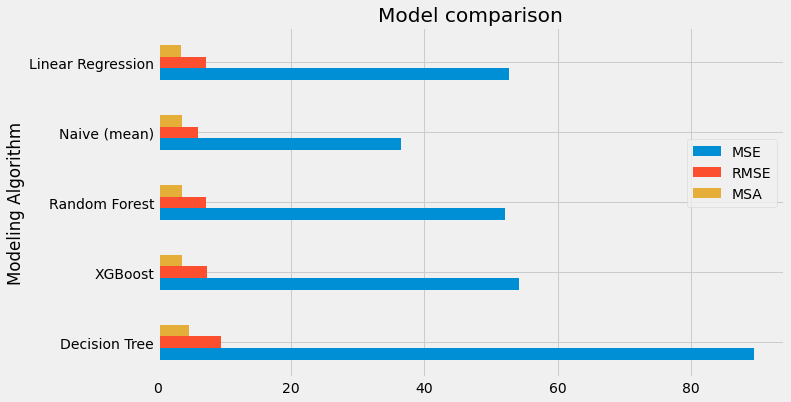

In [13]:
# plot model performances according to 3 traditional metrics
plt.style.use("fivethirtyeight")
ax = score_table.sort_values(by=["MSA"], ascending=False).plot(
    kind="barh", x="Modeling Algorithm", figsize=(10, 6), stacked=False
)
ax.legend(bbox_to_anchor=(1, 0.7))
plt.grid(which="minor", axis="x", color="k")
plt.title("Model comparison")
plt.show()
plt.close()

The best performances were obtained by random forest, linear regression models and xgboost.

## 5. Linear regression <a name="lr"></a>

In [14]:
# build the linear regression model using default settings
lr_model = LinearRegression(normalize=True)
lr_model.fit(X_train, y_train)

# prediction
y_pred = lr_model.predict(X_test)

In [15]:
compute_metrics(y_test, y_pred, model_name="Linear regression (default)")

MODEL: Linear regression (default)
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
MSE  =  52.78
RMSE =   7.26
MAE  =   3.52


In [16]:
# create a datraframe containing predicted and actual values
pred_actual = pd.DataFrame({"predictions": y_pred, "actual values": y_test})
pred_actual.loc[:, "average"] = y_train.mean()
pred_actual = pred_actual.reset_index(drop=True)
pred_actual.head(3)

,predictions,actual values,average
0,3.536382,3,4.225202
1,2.626250,0,4.225202
2,3.583544,0,4.225202


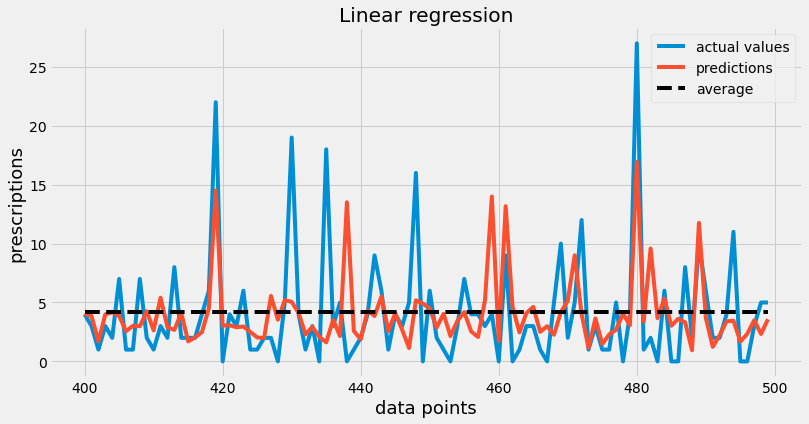

In [17]:
n_points = 500

plt.figure(figsize=(12, 6))
pred_actual["actual values"][
    400:n_points,
].plot.line()
pred_actual["predictions"][
    400:n_points,
].plot.line()
pred_actual["average"][
    400:n_points,
].plot.line(color="k", linestyle="--")

# plt.title(f'Decision Tree: RMSPE = {round(rmspe, 1)}%', size=20)
plt.xlabel("data points", size=18)
plt.ylabel("prescriptions", size=18)
plt.title("Linear regression")
plt.legend()
plt.show()

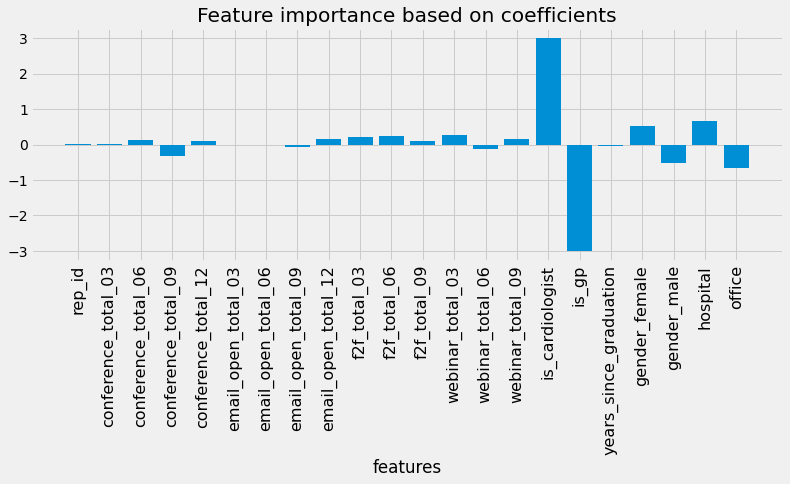

In [18]:
labels = list(df.columns)
labels = labels[:-1]

importance = lr_model.coef_

# summarize feature importance (uncomment the following 2 lines to see the values)
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.figure(figsize=(12, 4))
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(
    [r - 0.1 + 0.1 for r in range(len(labels))], labels, rotation=90, fontsize=16
)
plt.xlabel("features")
plt.title("Feature importance based on coefficients")
plt.show()

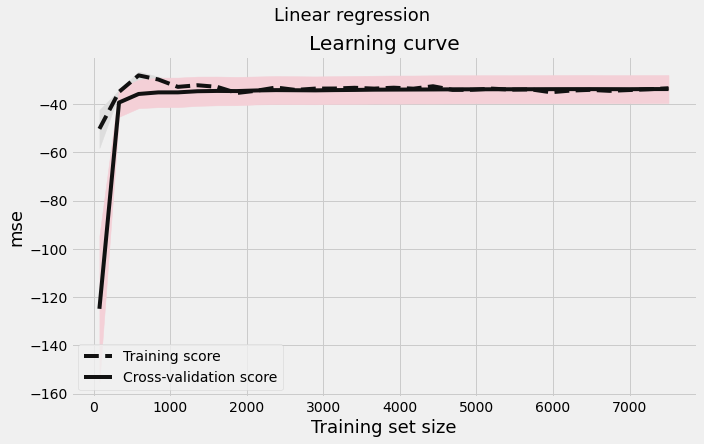

In [19]:
# from sklearn.model_selection import learning_curve
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_learning_curve(X, y, 3, LinearRegression(normalize=True), plt)
fig.suptitle("Linear regression", fontsize=18, y=1.03)
fig.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

## 6. Decision tree <a name="dt"></a>

In [20]:
# build the decision tree using default settings
dt_model = DecisionTreeRegressor(max_depth=3, random_state=42)
dt_model.fit(X_train, y_train)

# prediction
y_pred = dt_model.predict(X_test)

In [21]:
compute_metrics(y_test, y_pred, model_name="Decision Tree (default)")

MODEL: Decision Tree (default)
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
MSE  =  52.97
RMSE =   7.28
MAE  =   3.57


In [22]:
# create a datraframe containing predicted and actual values
pred_actual = pd.DataFrame({"predictions": y_pred, "actual values": y_test})
pred_actual.loc[:, "average"] = y_train.mean()
pred_actual = pred_actual.reset_index(drop=True)
pred_actual.head(3).round()

,predictions,actual values,average
0,3.0,3,4.0
1,3.0,0,4.0
2,4.0,0,4.0


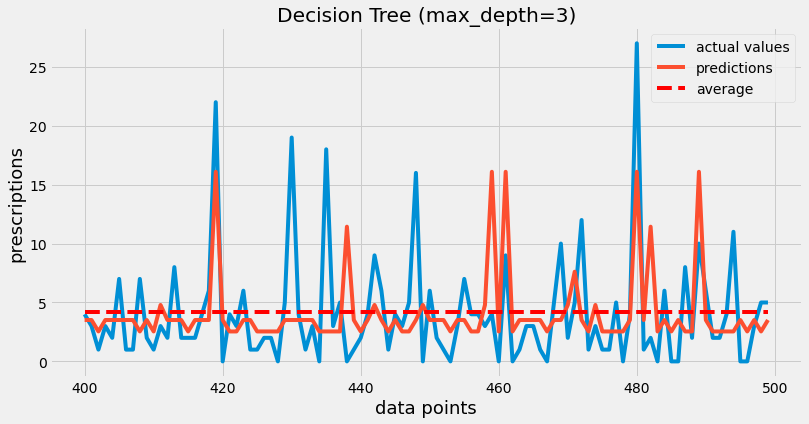

In [23]:
n_points = 500

plt.figure(figsize=(12, 6))
pred_actual["actual values"][
    400:n_points,
].plot.line()
pred_actual["predictions"][
    400:n_points,
].plot.line()
pred_actual["average"][
    400:n_points,
].plot.line(color="r", linestyle="--")

# plt.title(f'Decision Tree: RMSPE = {round(rmspe, 1)}%', size=20)
plt.xlabel("data points", size=18)
plt.ylabel("prescriptions", size=18)
plt.title("Decision Tree (max_depth=3)")
plt.legend()
plt.show()

In [24]:
feature_names = [
    "rep_id",
    "conference_total_03",
    "conference_total_06",
    "conference_total_09",
    "conference_total_12",
    "email_open_total_03",
    "email_open_total_06",
    "email_open_total_09",
    "email_open_total_12",
    "f2f_total_03",
    "f2f_total_06",
    "f2f_total_09",
    "webinar_total_03",
    "webinar_total_06",
    "webinar_total_09",
    "is_cardiologist",
    "is_gp",
    "years_since_graduation",
    "gender_female",
    "gender_male",
    "hospital",
    "office",
]

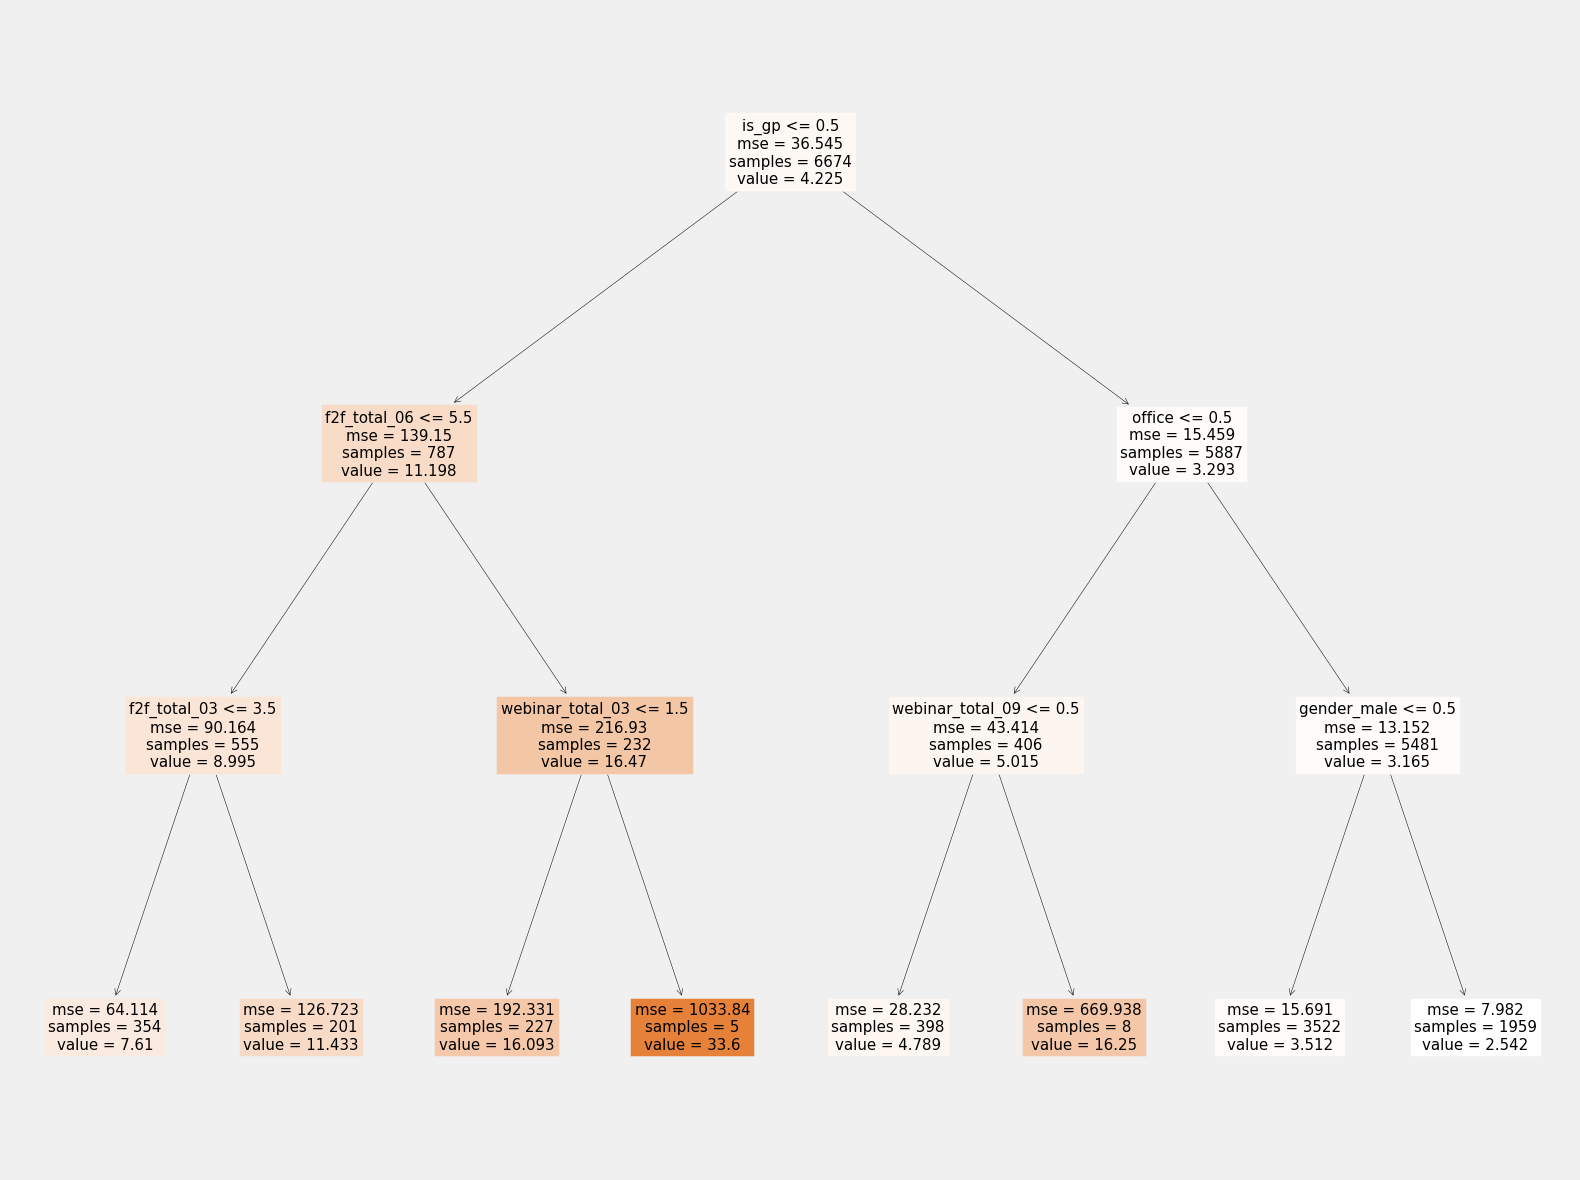

In [25]:
# visualize our tree
fig = plt.figure(figsize=(25, 20))
_ = tree.plot_tree(
    dt_model,
    feature_names=feature_names,
    filled=True,
)

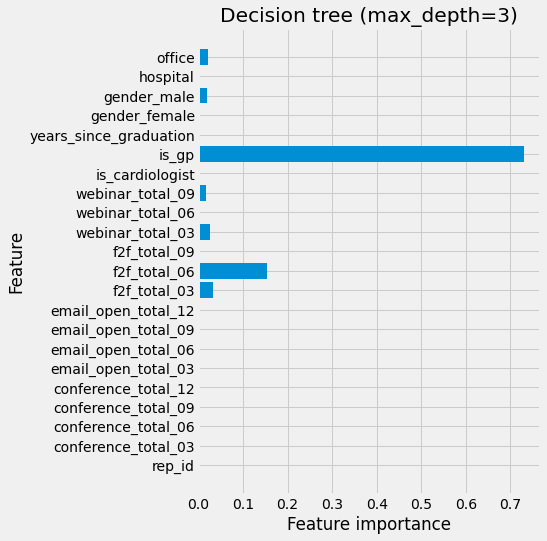

In [26]:
# plot feature importance for the 4 models
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

plt.subplot(1, 2, 1)
plot_feature_importance_tree(dt_model, X_train, "Decision tree (max_depth=3)", plt)

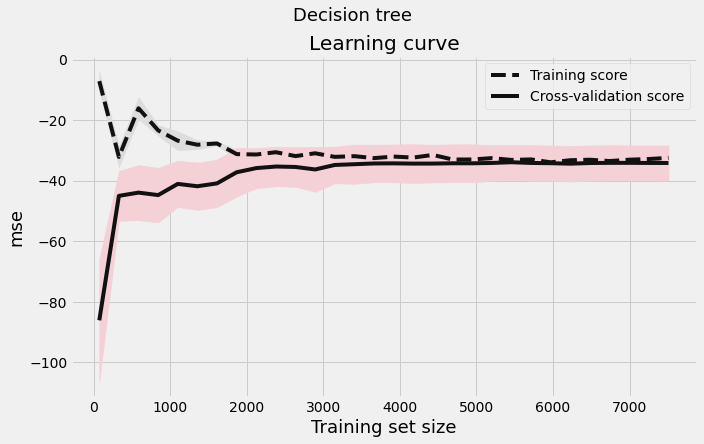

In [27]:
# from sklearn.model_selection import learning_curve
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_learning_curve(X, y, 3, DecisionTreeRegressor(max_depth=3, random_state=42), plt)
fig.suptitle("Decision tree", fontsize=18, y=1.03)
fig.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()